In [0]:
# 用 python 解壓縮, 解壓縮時不要解在 drive裏面, 會永久儲存, 為了節省空間直接解壓縮就好 in colab
import zipfile
# 從 drive/ My Drive 裡面的 train.zip 拿取檔案
f = zipfile.ZipFile("drive/My Drive/train.zip")
# 創一個資料夾 datasets 把 train.zip 解壓縮在裏面
f.extractall("./datasets")

In [0]:
# 找出這些擋名
import glob
catfs = glob.glob("datasets/train/cat.*.jpg")
# cat 答案為 0 這一類 * len(catfs)有這麼多個
catans = [0]* len(catfs)
dogfs = glob.glob("datasets/train/dog.*.jpg")
dogans = [1] * len(dogfs)

In [3]:
import pandas as pd
df = pd.DataFrame({
    "path":catfs + dogfs,
    "target":catans +dogans
})
df

,path,target
0,datasets/train/cat.11630.jpg,0
1,datasets/train/cat.3765.jpg,0
2,datasets/train/cat.591.jpg,0
3,datasets/train/cat.6686.jpg,0
4,datasets/train/cat.2384.jpg,0
...,...,...
24995,datasets/train/dog.9502.jpg,1
24996,datasets/train/dog.10694.jpg,1
24997,datasets/train/dog.7585.jpg,1
24998,datasets/train/dog.1878.jpg,1


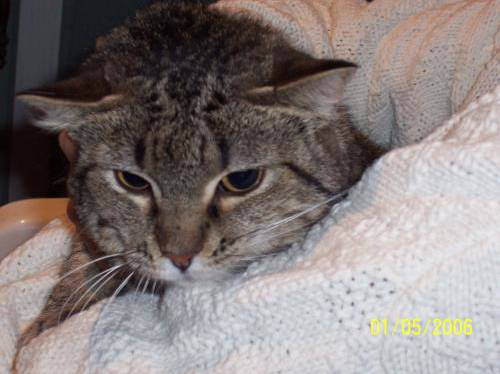

In [4]:
# 看圖片, 直接從 keras 裡面讀取圖片, 每張圖大小不同, 需要壓縮成大小相同
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing.image import load_img
idx = 20
load_img(df["path"][idx])

In [5]:
# 從 keras 裡面拿取 VGG 16的 CNN, 像素值參考: https://keras.io/zh/applications/
# include_top 是指有沒有要用 VGG1 6的 MLP 我們不要 所以一定 false
from tensorflow.keras.applications.vgg16 import VGG16
cnn = VGG16(include_top=False, input_shape=(224, 224, 3))
cnn.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [6]:
# input 和 output 都是一個 tensor 向量
cnn.output

<tf.Tensor 'block5_pool/Identity:0' shape=(None, 7, 7, 512) dtype=float32>

In [7]:
# 每一層模型都有一個屬性叫做 layers, 是一個 list
cnn.layers

In [8]:
# 開始疊模型, 第一種疊模型方法 sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
model = Sequential()
for l in cnn.layers:
  l.trainable = False  # !!!偷來的CNN已經訓練好了, 固定別再動參數!!!
  model.add(l)
model.add(Flatten())  # Flatten() 把像素拉開成 1D, 
model.add(Dense(128, activation="relu")) # 由於用比較少資料做訓練MLP, 因此可以用少一點神經元
model.add(Dense(2, activation="softmax")) # 只有兩個, 貓跟狗
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [9]:
# sequential 只能一層疊一層, 無法處理一次兩個輸入
# model 可以處理同時輸入兩張圖片, 經過卷積網路, 合成一張圖片, 再做成輸出
# model 建立時, 把input給他, 把output給他, 但中間的連接層要連接好
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
for l in cnn.layers:
  l.trainable = False  # 偷來的CNN已經訓練好了, 固定別再動參數
x = BatchNormalization()(cnn.output) # 0525_放在flatten完全不對
x = Flatten()(x) # 把cnn.output的資訊丟入 Faltten做成1D像素
x = Dense(64, activation="relu")(x) # 再把上述 x 丟進 Dense
x = Dropout(0.25)(x)
out = Dense(2, activation="softmax")(x)
Model2 = Model(inputs=cnn.input, outputs=out)
Model2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
# compile 做出訓練模型的條件, 用亂度衡量, adam(加速度, 步長優化), 準確率衡量
model.compile(loss=SparseCategoricalCrossentropy(),
              optimizer="adam",
              metrics=["accuracy"])

In [0]:
# 0525 start訓練以前,一定把所有的 list, series...-->轉成 nparray, 避免有空值情況發生
import numpy as np
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(np.array(df["path"]),
                                                    np.array(df["target"]),
                                                             test_size=0.1)

In [0]:
# 先讀出隨機的20張圖的索引, 
from tensorflow.keras.applications.vgg16 import preprocess_input
# retrun: (原圖(batch), 處理過後圖(batch), 答案(batch))
def dataflow(x, y, batch=20):
  idx = np.random.randint(0, x.shape[0], size=batch)
  x_batch, y_batch = x[idx], y[idx]
  x_ori, x_pre = [], []
  for fp in x_batch:
    img = load_img(fp, target_size=(244,244))
    img_np = np.array(img)
    # 原本的圖片存一份
    x_ori.append(img_np)
    img_pre = preprocess_input(img_np)
    # 預處理的圖片
    x_pre.append(img_pre)
  x_ori, x_pre = np.array(x_ori), np.array(x_pre)
  return (x_ori, x_pre, y_batch)


In [13]:
# 訓練 python裏面打下底線表示沒有用到, 不取名字
for i in range(70):
  print("-"*10, i, "-"*10)
  _, x, y = dataflow(x_train, y_train)
  result = model.train_on_batch(x, y)
  print("[Train]:", result)
  _, x, y = dataflow(x_test, y_test)
  result = model.test_on_batch(x, y)
  print("[Test]:", result)

---------- 0 ----------
[Train]: [17.616451263427734, 0.3499999940395355]
[Test]: [42.977447509765625, 0.6000000238418579]
---------- 1 ----------
[Train]: [39.837440490722656, 0.5]
[Test]: [1.6209030151367188, 0.8500000238418579]
---------- 2 ----------
[Train]: [3.168821334838867, 0.8500000238418579]
[Test]: [12.4422607421875, 0.8500000238418579]
---------- 3 ----------
[Train]: [8.961897850036621, 0.8999999761581421]
[Test]: [7.287466526031494, 0.8500000238418579]
---------- 4 ----------
[Train]: [10.667352676391602, 0.800000011920929]
[Test]: [10.097465515136719, 0.800000011920929]
---------- 5 ----------
[Train]: [9.979968070983887, 0.800000011920929]
[Test]: [0.6988478302955627, 0.949999988079071]
---------- 6 ----------
[Train]: [5.047055721282959, 0.8999999761581421]
[Test]: [6.927134037017822, 0.800000011920929]
---------- 7 ----------
[Train]: [0.0, 1.0]
[Test]: [7.289942264556885, 0.75]
---------- 8 ----------
[Train]: [0.2892913222312927, 0.949999988079071]
[Test]: [3.81274

In [14]:
# 上述所得到的loss飄忽不定, 表示有斜率是0, 沒法救, 
# 每一個深度學習的函式都在中間過去一點點, 不要落在非常右邊 非常左邊
# 非常右邊是斜率=0, 非常左邊也是斜率=0 斜率=0 沒有可以下降的踢度 無法調整
# step1, 做常態分部, step2, 
model.predict(x)

array([[1.0000000e+00, 2.0787637e-15],
       [0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 1.6937164e-28],
       [0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 1.6950668e-21],
       [1.0000000e+00, 1.1755149e-35],
       [1.0000000e+00, 2.3298521e-25],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [4.8317283e-35, 1.0000000e+00],
       [3.4392562e-17, 1.0000000e+00],
       [8.2311369e-25, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [9.9998903e-01, 1.0979646e-05],
       [1.0000000e+00, 0.0000000e+00]], dtype=float32)

In [0]:
# 如果遷移學習, BatchNormalization 要加上 把CNN跟MLP做一個結合
# 遷移學習, 如果訓練有不好, Dense(64, activation="relu")(x) 減少神經元
# 從128 --> 64 表現比較好, 由於遷移學習參數不多, 適當減少可以處理比較好
# 遷移學習可以不用太多圖片, 可以訓練出不錯的模型, 速度又快 但要注意原本的CNN有沒有做過類似的東西

In [17]:
# predict_classes: 用來預測機率的方法, 得到的是類別 但 model 沒有
# 可以用 predict + argmax = predict_classes
timg, tx, ty = dataflow(x_test, y_test, 500)
model.evaluate(tx, ty)
# agmax: 幫你找到最大值的 index, axis=-1 == axis = 1 
pre = model.predict(tx).argmax(axis=1)

16/16 [==============================] - 3s 195ms/step - loss: 0.5677 - accuracy: 0.9620


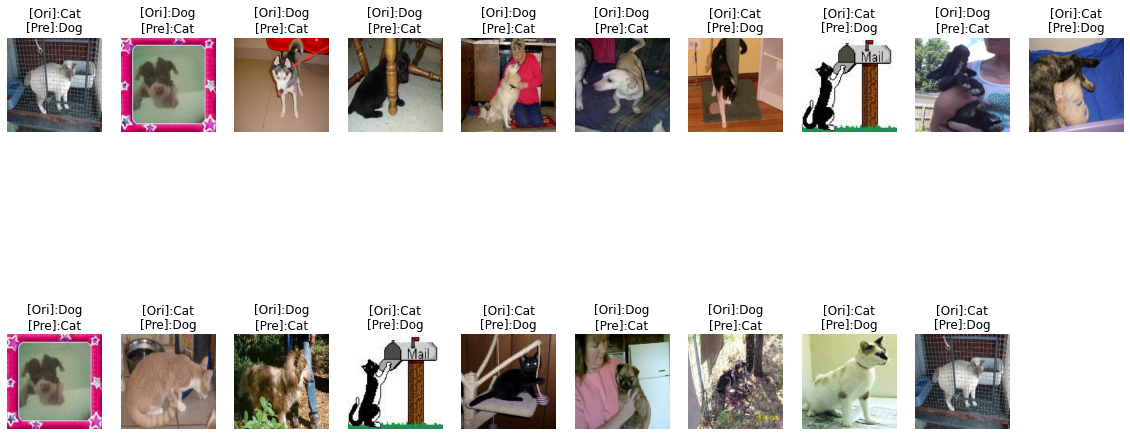

In [18]:
# 畫圖
# nonzero: 取出是True的index
# (x座標, y座標, z座標)
trans = ["Cat", "Dog"]
idx = np.nonzero(pre != ty)[0]
# 預測錯誤的圖
false_img = timg[idx]
false_answer = ty[idx]
false_predict = pre[idx]

# 把圖變大一點才塞的下
plt.figure(figsize=(20, 10))
width = 10
height = len(false_img) // width + 1
for i, img in enumerate(false_img):
    plt.subplot(height, width, i+1)
    plt.axis("off")
    t = "[Ori]:{}\n[Pre]:{}".format(trans[false_answer[i]],
                                    trans[false_predict[i]])
    plt.title(t)
    plt.imshow(img)